# Atmospheric Water Vapor Lake project

In [1]:
#### =============================================================================
#### IMPORT PACKAGES
#### =============================================================================
from os import listdir
from os.path import isfile, join

In [3]:
import cartopy.crs as ccrs
import matplotlib.animation as animation

import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
from IPython.display import HTML
plt.rcParams["animation.html"] = "jshtml"

In [4]:
from scipy.stats import binned_statistic
import pandas as pd

In [5]:
import dask #parallel computing library

## Task 2 - Merge the interpolated IMERG and minimal MERRA data, perform groupby based on 'distance' and plot them
## CASE 1: 2014_04_12_21_lat5p095N

In [6]:
remapped_data_merra = xr.open_dataset('/home/snigdha/workspace/2014_04_12_21_lat5p095N_remapped.nc') 

In [10]:
remapped_data_merra

<xarray.Dataset>
Dimensions:            (time: 172, lon: 449, lat: 217)
Coordinates:
  * time               (time) datetime64[ns] 2014-04-05T17:30:00 ... 2014-04-...
  * lon                (lon) float64 44.45 44.55 44.65 ... 89.05 89.15 89.25
  * lat                (lat) float64 -3.95 -3.85 -3.75 ... 17.45 17.55 17.65
Data variables:
    prectot            (time, lat, lon) float32 ...
    tqv                (time, lat, lon) float32 ...
    distance           (time, lat, lon) float32 ...
    dir_from_centroid  (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.2.4 (https://mpimet.mpg.de...
    Conventions:  COARDS\nGrADS
    title:        MERRA-2 tavg1_2d_flx_Nx: 2d,1-Hourly,Time-Averaged,Single-L...
    dataType:     Grid
    history:      Wed Sep 06 14:52:17 2023: cdo -remapcon,/home/snigdha/Docum...
    CDO:          Climate Data Operators version 2.2.2 (https://mpimet.mpg.de...

In [11]:
original_imerg_data =  xr.open_dataset('/home/snigdha/Documents/LAKEBYLAKE/IMERG/2014_04_12_21_lat5p095N_IMERG_precipc_hourly.nc')

In [12]:
original_imerg_data

<xarray.Dataset>
Dimensions:  (time: 173, lat: 217, lon: 449)
Coordinates:
  * time     (time) datetime64[ns] 2014-04-05T17:00:00 ... 2014-04-12T21:00:00
  * lat      (lat) float64 -3.95 -3.85 -3.75 -3.65 ... 17.35 17.45 17.55 17.65
  * lon      (lon) float64 44.45 44.55 44.65 44.75 ... 88.95 89.05 89.15 89.25
Data variables:
    precipc  (time, lat, lon) float32 ...

### Interpolation by time

In [13]:
original_imerg_data_interp = original_imerg_data.interp(time=remapped_data_merra['time'])

In [14]:
original_imerg_data_interp

<xarray.Dataset>
Dimensions:  (lat: 217, lon: 449, time: 172)
Coordinates:
  * lat      (lat) float64 -3.95 -3.85 -3.75 -3.65 ... 17.35 17.45 17.55 17.65
  * lon      (lon) float64 44.45 44.55 44.65 44.75 ... 88.95 89.05 89.15 89.25
  * time     (time) datetime64[ns] 2014-04-05T17:30:00 ... 2014-04-12T20:30:00
Data variables:
    precipc  (time, lat, lon) float64 1.409e+20 1.035e-19 6.778e-20 ... 0.0 0.0

### Merge the interpolated IMERG data and MERRA 

In [15]:
merged_ds = xr.merge([original_imerg_data_interp, remapped_data_merra])

### Process the merged dataset to get a new dataset with spatially averaged data variables grouped by 'distance_bin' over time. The new dataset would have two dimensions then: 'time' , 'distance_bins'

In [24]:
# Chunk the 'time' dimension in merged_ds into individual slices for parallel computing
merged_ds = merged_ds.chunk({'time': 1})

# Define a function to process one time slice of the dataset
def process_one_time_slice(ds_t):
  
    # Group the data by distance bins, ranging from -2 to 4 with intervals of 0.1
    ds_grouped_t = ds_t.groupby_bins('distance', bins=np.arange(-2, 4, 0.1))
  
    # Initialize an empty xarray Dataset to hold reduced (averaged) data
    ds_reduced_t = xr.Dataset()
  
    # Loop through each distance bin group
    for name, group in ds_grouped_t:
      
        # Compute the mean of each group along the 'stacked_lat_lon' dimension
        reduced_data_array = group.mean(dim='stacked_lat_lon').to_array()
      
        # Add this reduced data array to the new xarray Dataset
        ds_reduced_t[str(name)] = reduced_data_array
  
    # Return the reduced dataset for this time slice
    return ds_reduced_t

# Generate a list of Dask delayed objects for each time slice in the original merged dataset
lazy_results = [dask.delayed(process_one_time_slice)(merged_ds.sel(time=t)) for t in merged_ds['time'].values]

# Execute the Dask delayed tasks to obtain the computed results
computed_results = dask.compute(*lazy_results)

# Create a dictionary to map each time slice to its corresponding processed dataset
new_datasets = {t: ds for t, ds in zip(merged_ds['time'].values, computed_results)}


/home/snigdha/anaconda3/envs/basic/lib/python3.11/site-packages/numpy/core/numeric.py:407: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(res, fill_value, casting='unsafe')
/home/snigdha/anaconda3/envs/basic/lib/python3.11/site-packages/numpy/core/numeric.py:407: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(res, fill_value, casting='unsafe')
/home/snigdha/anaconda3/envs/basic/lib/python3.11/site-packages/numpy/core/numeric.py:407: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(res, fill_value, casting='unsafe')
/home/snigdha/anaconda3/envs/basic/lib/python3.11/site-packages/numpy/core/numeric.py:407: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(res, fill_value, casting='unsafe')
/home/snigdha/anaconda3/envs/basic/lib/python3.11/site-packages/numpy/core/numeric.py:407: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(res, fill_value, casting='unsafe')
/home/snigdha/anacon

In [18]:
new_datasets.keys() # The timestamps are the keys of the new dataset

dict_keys([numpy.datetime64('2014-04-05T17:30:00.000000000'), numpy.datetime64('2014-04-05T18:30:00.000000000'), numpy.datetime64('2014-04-05T19:30:00.000000000'), numpy.datetime64('2014-04-05T20:30:00.000000000'), numpy.datetime64('2014-04-05T21:30:00.000000000'), numpy.datetime64('2014-04-05T22:30:00.000000000'), numpy.datetime64('2014-04-05T23:30:00.000000000'), numpy.datetime64('2014-04-06T00:30:00.000000000'), numpy.datetime64('2014-04-06T01:30:00.000000000'), numpy.datetime64('2014-04-06T02:30:00.000000000'), numpy.datetime64('2014-04-06T03:30:00.000000000'), numpy.datetime64('2014-04-06T04:30:00.000000000'), numpy.datetime64('2014-04-06T05:30:00.000000000'), numpy.datetime64('2014-04-06T06:30:00.000000000'), numpy.datetime64('2014-04-06T07:30:00.000000000'), numpy.datetime64('2014-04-06T08:30:00.000000000'), numpy.datetime64('2014-04-06T09:30:00.000000000'), numpy.datetime64('2014-04-06T10:30:00.000000000'), numpy.datetime64('2014-04-06T11:30:00.000000000'), numpy.datetime64('20

In [21]:
data_onetimestep = new_datasets[np.datetime64('2014-04-05T17:30:00.000000000')] # Let's select one timestep

In [20]:
data_onetimestep 

<xarray.Dataset>
Dimensions:           (variable: 5)
Coordinates:
    time              datetime64[ns] 2014-04-05T17:30:00
  * variable          (variable) object 'precipc' ... 'dir_from_centroid'
Data variables: (12/59)
    (-2.0, -1.9]      (variable) float64 0.1726 8.178e-05 45.72 -1.948 222.5
    (-1.9, -1.8]      (variable) float64 0.3424 5.501e-05 44.17 -1.853 231.1
    (-1.8, -1.7]      (variable) float64 0.1851 4.164e-05 43.49 -1.756 229.9
    (-1.7, -1.6]      (variable) float64 0.1434 6.281e-05 44.95 -1.655 218.8
    (-1.6, -1.5]      (variable) float64 0.108 3.004e-05 39.44 -1.549 241.1
    (-1.5, -1.4]      (variable) float64 0.1711 4.546e-05 43.47 -1.45 232.2
    ...                ...
    (3.3, 3.4]        (variable) float64 0.1761 5.313e-06 32.31 3.351 220.3
    (3.4, 3.5]        (variable) float64 0.2724 6.567e-06 32.99 3.453 196.9
    (3.5, 3.6]        (variable) float64 0.1923 4.938e-06 33.32 3.547 221.0
    (3.6, 3.7]        (variable) float64 0.1382 7.057e-06 33.48 3.643 194.2
    (3.7, 3.8]        (variable) float64 0.1971 4.41e-06 34.28 3.751 214.4
    (3.8, 3.9]        (variable) float64 0.1626 6.438e-06 34.48 3.846 211.0

In [23]:
# Initialize an empty list to hold merged data grouped by variables
list_merged_data_grouped = []

# Loop through the keys (variable names) in the data_vars attribute of the data_onetimestep object
# data_vars contains the data variables that exist in the xarray Dataset
for items in list(data_onetimestep.data_vars.keys()):
  
    # Append the NumPy array values of each data variable to the list
    list_merged_data_grouped.append(data_onetimestep[items].values)

# Convert the list of merged data to a NumPy array for efficient numerical operations
list_merged_data_grouped = np.array(list_merged_data_grouped)


In [25]:
list_merged_data_grouped

array([[ 1.72559413e-01,  8.17798282e-05,  4.57222557e+01,
        -1.94824946e+00,  2.22466614e+02],
       [ 3.42371490e-01,  5.50102923e-05,  4.41736526e+01,
        -1.85329926e+00,  2.31125412e+02],
       [ 1.85126437e-01,  4.16373441e-05,  4.34915161e+01,
        -1.75571513e+00,  2.29947906e+02],
       [ 1.43412334e-01,  6.28121124e-05,  4.49493637e+01,
        -1.65458071e+00,  2.18820145e+02],
       [ 1.07962816e-01,  3.00411921e-05,  3.94418259e+01,
        -1.54861760e+00,  2.41133072e+02],
       [ 1.71054369e-01,  4.54642322e-05,  4.34667969e+01,
        -1.44969928e+00,  2.32163437e+02],
       [ 2.94374701e-01,  2.98546456e-05,  4.18408432e+01,
        -1.34010959e+00,  2.31990280e+02],
       [ 2.37299405e-01,  2.90993630e-05,  4.06335373e+01,
        -1.25381804e+00,  2.33601303e+02],
       [ 1.70463418e-01,  3.46008783e-05,  4.33263969e+01,
        -1.15146768e+00,  2.31455124e+02],
       [ 1.70411722e-01,  3.17759259e-05,  4.12552261e+01,
        -1.04635274e+00

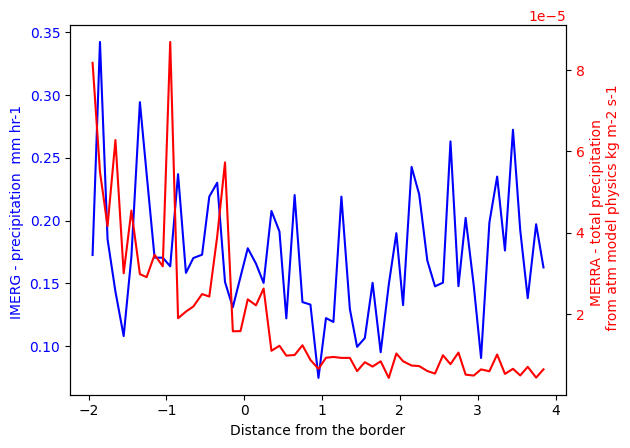

In [32]:
fig, ax1 = plt.subplots()

ax1.plot(list_merged_data_grouped[:,3], list_merged_data_grouped[:,0], color='blue', label='IMERG - precipitation  mm hr-1 ')
ax1.set_xlabel('Distance from the border')
ax1.set_ylabel('IMERG - precipitation  mm hr-1 ', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create the second plot with its y-axis on the right-hand side
ax2 = ax1.twinx()
ax2.plot(list_merged_data_grouped[:,3], list_merged_data_grouped[:,1], color='red', label='MERRA - total precipitation from atm model physics kg m-2 s-1')
ax2.set_ylabel('MERRA - total precipitation \n from atm model physics kg m-2 s-1', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Show the plot
plt.show()